Spoken digit recognition using the Free Spoken Digit Dataset (FSDD)

At first, import packages to be used for the experiments

In [1]:
import os, sys
cwd = os.getcwd()
module_path = os.path.dirname(cwd)  # target working directory

sys.path = [item for item in sys.path if item != module_path]  # remove module_path from sys.path
sys.path.append(module_path)  # add module_path to sys.path

import glob
import os
import numpy as np
import pandas as pd
from sklearn.base import clone
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, ParameterGrid, cross_validate

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import make_scorer, ConfusionMatrixDisplay
from sklearn.cluster import MiniBatchKMeans
from sklearn.utils import shuffle
from sklearn.utils.fixes import loguniform
from scipy.stats import uniform
from joblib import Parallel, delayed, dump, load
from pyrcn.echo_state_network import SeqToLabelESNClassifier
from pyrcn.base import PredefinedWeightsInputToNode, NodeToNode
from pyrcn.metrics import accuracy_score, classification_report, confusion_matrix
from pyrcn.model_selection import SequentialSearchCV
import seaborn as sns
import matplotlib
from matplotlib import pyplot as plt
#Options
plt.rc('image', cmap='RdBu')
plt.rc('font', family='serif', serif='Times')
plt.rc('text', usetex=True)
plt.rc('xtick', labelsize=8)
plt.rc('ytick', labelsize=8)
plt.rc('axes', labelsize=8)

from IPython.display import set_matplotlib_formats
set_matplotlib_formats('png', 'pdf')
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib import ticker
import librosa
import librosa.display

Print number of files that are included in the dataset

In [4]:
all_files = glob.glob(r"E:\free-spoken-digit-dataset\recordings\*.wav")
print(len(all_files))

3000


Feature visualization

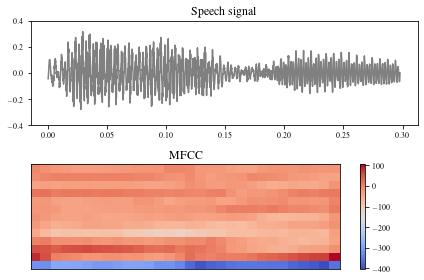

In [5]:
# Load the audio signal and normalize it.
basename = os.path.basename(all_files[0]).split('.')[0]
x, sr = librosa.core.load(all_files[0], sr=None, mono=False)
# x /= np.max(np.abs(x))
mfcc = librosa.feature.mfcc(y=x, sr=sr, hop_length=int(0.01*sr), n_fft=256, htk=True, n_mels=100, n_mfcc=13)
# X = np.vstack((mfcc, mfcc_delta, mfcc_delta2))
X = mfcc.T
label = int(basename.split('_')[0])
# Define time axis in seconds
t = np.arange(len(x)) / sr

plt.subplot(2, 1, 1)
plt.plot(t, x, color='gray')
# plt.xlabel('Time (seconds)')
# plt.ylabel('Amplitude')
# plt.xlim([t[0], t[-1]])
plt.ylim([-0.4, 0.4])
plt.title("Speech signal")
plt.subplot(2, 1, 2)
librosa.display.specshow(mfcc)
plt.title('MFCC')
plt.colorbar()
plt.tight_layout()

Extract features and labels from all signals

In [6]:
X_train = []
X_test = []
y_train = []
y_test = []
print("extracting features...")
for k, f in enumerate(all_files):
    basename = os.path.basename(f).split('.')[0]
    # Get label (0-9) of recording.
    label = int(basename.split('_')[0])
    idx = int(basename.split('_')[2])
    # Load the audio signal and normalize it.
    x, sr = librosa.core.load(f, sr=None, mono=False)
    # x /= np.max(np.abs(x))
    mfcc = librosa.feature.mfcc(y=x, sr=sr, hop_length=int(0.01*sr), n_fft=256, htk=True, n_mels=100, n_mfcc=13)
    mfcc_delta = librosa.feature.delta(mfcc)
    mfcc_delta2 = librosa.feature.delta(mfcc, order=2)
    if idx <= 4:
        X_test.append(mfcc.T)
        y_test.append(label)
    else:
        X_train.append(mfcc.T)
        y_train.append(label)
print("done!")

extracting features...
done!


## Normalize all features using the StandardScaler from scikit-learn."

In [7]:
scaler = StandardScaler().fit(X=np.vstack(X_train + X_test))
X_train_scaled = np.empty(shape=(len(X_train),), dtype=object)
X_test_scaled = np.empty(shape=(len(X_test),), dtype=object)
y_train = np.array(y_train, dtype=object)
X_train, X_train_scaled, y_train = shuffle(X_train, X_train_scaled, y_train)
y_test = np.array(y_test, dtype=object)
for k in range(len(X_train)):
    X_train_scaled[k] = scaler.transform(X_train[k])
    y_train[k] = np.atleast_1d(y_train[k]).astype(int)
for k in range(len(X_test)):
    X_test_scaled[k] = scaler.transform(X_test[k])
    y_test[k] = np.atleast_1d(y_test[k]).astype(int)

Validate training and test sizes

In [8]:
print(len(X_train), len(y_train), X_train[0].shape, y_train[0])
print(len(X_test), len(y_test), X_test[0].shape, y_test[0])

2700 2700 (38, 13) [0]
300 300 (30, 13) [0]


Feature visualization

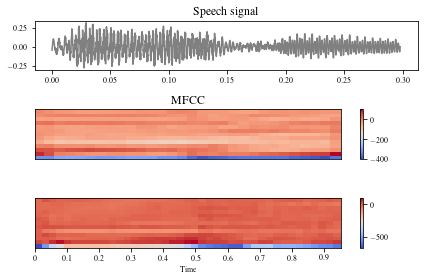

In [7]:
# Load the audio signal and normalize it.
basename = os.path.basename(all_files[0]).split('.')[0]
x, sr = librosa.core.load(all_files[0], sr=None, mono=False)
# x /= np.max(np.abs(x))
mfcc = librosa.feature.mfcc(y=x, sr=sr, hop_length=int(0.01*sr), n_fft=256, htk=True, n_mels=100, n_mfcc=13)
X = mfcc.T
label = int(basename.split('_')[0])
# Define time axis in seconds
t = np.arange(len(x)) / sr

plt.subplot(3, 1, 1)
plt.plot(t, x, color='gray')
# plt.xlabel('Time (seconds)')
# plt.ylabel('Amplitude')
# plt.xlim([t[0], t[-1]])
# plt.ylim([-0.4, 0.4])
plt.title("Speech signal")
plt.subplot(3, 1, 2)
librosa.display.specshow(mfcc)
plt.title('MFCC')
plt.colorbar()
plt.subplot(3, 1, 3)
librosa.display.specshow(X_train[0].T, x_axis='time')
plt.colorbar()
plt.tight_layout()

Hyperparameter optimization

In [8]:
initially_fixed_params = {'hidden_layer_size': 400,
                          'k_in': 10,
                          'input_scaling': 0.4,
                          'input_activation': 'identity',
                          'bias_scaling': 0.0,
                          'spectral_radius': 0.0,
                          'leakage': 0.1,
                          'k_rec': 10,
                          'reservoir_activation': 'tanh',
                          'bidirectional': False,
                          'wash_out': 0,
                          'continuation': False,
                          'alpha': 1e-3,
                          'random_state': 42}

step1_esn_params = {'input_scaling': uniform(loc=1e-2, scale=1),
                    'spectral_radius': uniform(loc=0, scale=2)}

step2_esn_params = {'leakage': loguniform(1e-5, 1e0)}
step3_esn_params = {'bias_scaling': np.linspace(0.0, 1.0, 11)}
step4_esn_params = {'alpha': loguniform(1e-5, 1e1)}

kwargs_step1 = {'n_iter': 200, 'random_state': 42, 'verbose': 1, 'n_jobs': -1, 'scoring': make_scorer(accuracy_score)}
kwargs_step2 = {'n_iter': 50, 'random_state': 42, 'verbose': 1, 'n_jobs': -1, 'scoring': make_scorer(accuracy_score)}
kwargs_step3 = {'verbose': 1, 'n_jobs': -1, 'scoring': make_scorer(accuracy_score)}
kwargs_step4 = {'n_iter': 50, 'random_state': 42, 'verbose': 1, 'n_jobs': -1, 'scoring': make_scorer(accuracy_score)}

# The searches are defined similarly to the steps of a sklearn.pipeline.Pipeline:
searches = [('step1', RandomizedSearchCV, step1_esn_params, kwargs_step1),
            ('step2', RandomizedSearchCV, step2_esn_params, kwargs_step2),
            ('step3', GridSearchCV, step3_esn_params, kwargs_step3),
            ('step4', RandomizedSearchCV, step4_esn_params, kwargs_step4)]

base_esn = SeqToLabelESNClassifier(**initially_fixed_params)

try:
    sequential_search = load("../sequential_search_fsdd.joblib")
except FileNotFoundError:
    sequential_search = SequentialSearchCV(base_esn, searches=searches).fit(X_train_scaled, y_train)
    dump(sequential_search, "../sequential_search_fsdd.joblib")

Test the final model on the training and test set

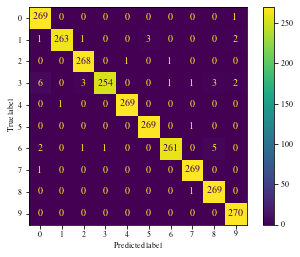

Classification training report for estimator SeqToLabelESNClassifier(input_to_node=InputToNode(bias_scaling=0.8,
                                                  hidden_layer_size=400,
                                                  input_activation='identity',
                                                  input_scaling=0.9756320330745594,
                                                  k_in=10,
                                                  sparsity=0.7692307692307693),
                        node_to_node=NodeToNode(hidden_layer_size=400, k_rec=10,
                                                leakage=0.08431013932082461,
                                                sparsity=0.025,
                                                spectral_radius=1.6167946962329223),
                        regressor=IncrementalRegression(alpha=0.0017670169402947947)):
              precision    recall  f1-score   support

           0  0.9641577061 0.9962962963 0.9799635701       270


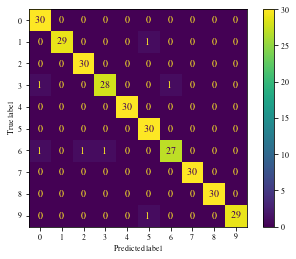

Classification test report for estimator SeqToLabelESNClassifier(input_to_node=InputToNode(bias_scaling=0.8,
                                                  hidden_layer_size=400,
                                                  input_activation='identity',
                                                  input_scaling=0.9756320330745594,
                                                  k_in=10,
                                                  sparsity=0.7692307692307693),
                        node_to_node=NodeToNode(hidden_layer_size=400, k_rec=10,
                                                leakage=0.08431013932082461,
                                                sparsity=0.025,
                                                spectral_radius=1.6167946962329223),
                        regressor=IncrementalRegression(alpha=0.0017670169402947947)):
              precision    recall  f1-score   support

           0  0.9375000000 1.0000000000 0.9677419355        30
    

In [9]:
esn = sequential_search.best_estimator_
y_pred_train = esn.predict(X=X_train_scaled)
cm = confusion_matrix(y_train, y_pred_train)
cm_display = ConfusionMatrixDisplay(cm, display_labels=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]).plot()
plt.show()
print("Classification training report for estimator %s:\n%s\n" % (esn, classification_report(y_train, y_pred_train, digits=10)))

y_pred_test = esn.predict(X=X_test_scaled)
cm = confusion_matrix(y_test, y_pred_test)
cm_display = ConfusionMatrixDisplay(cm, display_labels=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]).plot()
plt.show()
print("Classification test report for estimator %s:\n%s\n" % (esn, classification_report(y_test, y_pred_test, digits=10)))

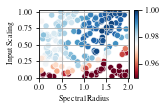

In [10]:
df = pd.DataFrame(sequential_search.all_cv_results_["step1"])
df.mean_test_score = df.mean_test_score.clip(lower=0.95)
fig = plt.figure()
ax = sns.scatterplot(x="param_spectral_radius", y="param_input_scaling", hue="mean_test_score", palette='RdBu', data=df)
plt.xlabel("Spectral Radius")
plt.ylabel("Input Scaling")

norm = plt.Normalize(0.95, 1.0)
sm = plt.cm.ScalarMappable(cmap="RdBu", norm=norm)
sm.set_array([])
plt.xlim((0, 2.01))
plt.ylim((0, 1.03))

# Remove the legend and add a colorbar
ax.get_legend().remove()
ax.figure.colorbar(sm)
fig.set_size_inches(2, 1.25)
ax.yaxis.set_major_locator(ticker.MaxNLocator(5))
ax.xaxis.set_major_locator(ticker.MaxNLocator(5))
plt.grid()
plt.savefig('Basic_ESN_IS_SR.pdf', bbox_inches='tight', pad_inches=0)

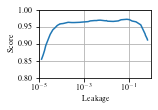

In [11]:
df = pd.DataFrame(sequential_search.all_cv_results_["step2"])
fig = plt.figure()
fig.set_size_inches(2, 1.25)
ax = sns.lineplot(data=df, x="param_leakage", y="mean_test_score")
ax.set_xscale('log')
plt.xlabel("Leakage")
plt.ylabel("Score")
plt.xlim((1e-5, 1e0))
plt.ylim((0.8, 1.0))
# ax.xaxis.set_major_locator(ticker.MaxNLocator(10))
ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('%.2f'))
plt.grid()
plt.savefig('Basic_ESN_LR.pdf', bbox_inches='tight', pad_inches=0)

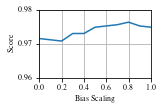

In [12]:
df = pd.DataFrame(sequential_search.all_cv_results_["step3"])
fig = plt.figure()
fig.set_size_inches(2, 1.25)
ax = sns.lineplot(data=df, x="param_bias_scaling", y="mean_test_score")
plt.xlabel("Bias Scaling")
plt.ylabel("Score")
plt.xlim((0, 1))
plt.ylim((0.96, 0.98))
ax.xaxis.set_major_locator(ticker.MaxNLocator(5))
ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('%.2f'))
plt.grid()
plt.savefig('Basic_ESN_BS.pdf', bbox_inches='tight', pad_inches=0)

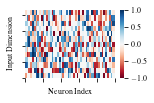

In [13]:
idx = np.random.randint(0, 400, 50)

fig = plt.figure()
fig.set_size_inches(2, 1.25)
ax = sns.heatmap(data=sequential_search.best_estimator_.input_to_node.input_weights.todense()[:, idx], cmap="RdBu", vmin=-1.0, vmax=1.0)
ax.invert_yaxis()
ax.yaxis.set_major_locator(ticker.MaxNLocator(5))
ax.xaxis.set_major_locator(ticker.MaxNLocator(5))
plt.xlabel("Neuron Index")
plt.ylabel("Input Dimension")
# plt.imshow(sequential_search.best_estimator_.input_to_node.input_weights.todense()[:, idx])
# plt.colorbar()
plt.savefig('Basic_ESN_Input_Weights.pdf', bbox_inches='tight', pad_inches=0)

Increase the reservoir size

In [ ]:
print(sequential_search.all_best_params_)
print(sequential_search.all_best_score_)
base_esn = clone(sequential_search.best_estimator_)

param_grid = {'hidden_layer_size': [50, 100, 200, 400, 800, 1600, 3200, 6400],
              'random_state': range(1, 11)}

for params in ParameterGrid(param_grid):
    esn = clone(base_esn).set_params(**params).fit(X=X_train_scaled, y=y_train, n_jobs=8)
    score = accuracy_score(y_test, esn.predict(X_test_scaled))
    print("ESN with params {0} achieved score of {1}".format(params, score))

K-Means Clustering

In [9]:
kmeans = MiniBatchKMeans(n_clusters=400, n_init=200, reassignment_ratio=0, max_no_improvement=50, init='k-means++', verbose=2, random_state=0)
kmeans.fit(X=np.concatenate(np.concatenate((X_train_scaled, X_test_scaled))))
w_in = np.divide(kmeans.cluster_centers_, np.linalg.norm(kmeans.cluster_centers_, axis=1)[:, None])
w_in = np.pad(w_in, ((0, 1600 - 400), (0, 0)), mode='constant', constant_values=0)

Init 1/200 with method: k-means++


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)


Inertia for init 1/200: 327.990662
Init 2/200 with method: k-means++


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)


Inertia for init 2/200: 334.455536
Init 3/200 with method: k-means++


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)


Inertia for init 3/200: 391.298218
Init 4/200 with method: k-means++


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)


Inertia for init 4/200: 375.644836
Init 5/200 with method: k-means++


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)


Inertia for init 5/200: 367.723206
Init 6/200 with method: k-means++


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)


Inertia for init 6/200: 342.951599
Init 7/200 with method: k-means++


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)


Inertia for init 7/200: 355.770508
Init 8/200 with method: k-means++


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)


Inertia for init 8/200: 364.470520
Init 9/200 with method: k-means++


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)


Inertia for init 9/200: 394.145905
Init 10/200 with method: k-means++


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)


Inertia for init 10/200: 384.010284
Init 11/200 with method: k-means++


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)


Inertia for init 11/200: 351.883453
Init 12/200 with method: k-means++


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)


Inertia for init 12/200: 353.252869
Init 13/200 with method: k-means++


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)


Inertia for init 13/200: 359.086639
Init 14/200 with method: k-means++


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)


Inertia for init 14/200: 330.806793
Init 15/200 with method: k-means++


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)


Inertia for init 15/200: 373.444611
Init 16/200 with method: k-means++


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)


Inertia for init 16/200: 334.299438
Init 17/200 with method: k-means++


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)


Inertia for init 17/200: 401.733124
Init 18/200 with method: k-means++


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)


Inertia for init 18/200: 359.350983
Init 19/200 with method: k-means++


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)


Inertia for init 19/200: 382.343719
Init 20/200 with method: k-means++


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)


Inertia for init 20/200: 395.038635
Init 21/200 with method: k-means++


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)


Inertia for init 21/200: 404.066101
Init 22/200 with method: k-means++


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)


Inertia for init 22/200: 368.210388
Init 23/200 with method: k-means++


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)


Inertia for init 23/200: 370.170837
Init 24/200 with method: k-means++


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)


Inertia for init 24/200: 377.314911
Init 25/200 with method: k-means++


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)


Inertia for init 25/200: 371.060638
Init 26/200 with method: k-means++


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)


Inertia for init 26/200: 412.468475
Init 27/200 with method: k-means++


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)


Inertia for init 27/200: 365.177673
Init 28/200 with method: k-means++


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)


Inertia for init 28/200: 373.889740
Init 29/200 with method: k-means++


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)


Inertia for init 29/200: 396.270874
Init 30/200 with method: k-means++


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)


Inertia for init 30/200: 397.854156
Init 31/200 with method: k-means++


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)


Inertia for init 31/200: 360.832703
Init 32/200 with method: k-means++


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)


Inertia for init 32/200: 378.941040
Init 33/200 with method: k-means++


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)


Inertia for init 33/200: 394.813477
Init 34/200 with method: k-means++


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)


Inertia for init 34/200: 354.979553
Init 35/200 with method: k-means++


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)


Inertia for init 35/200: 401.727051
Init 36/200 with method: k-means++


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)


Inertia for init 36/200: 382.032379
Init 37/200 with method: k-means++


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)


Inertia for init 37/200: 387.602722
Init 38/200 with method: k-means++


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)


Inertia for init 38/200: 349.487854
Init 39/200 with method: k-means++


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)


Inertia for init 39/200: 394.721405
Init 40/200 with method: k-means++


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)


Inertia for init 40/200: 359.276398
Init 41/200 with method: k-means++


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)


Inertia for init 41/200: 285.195587
Init 42/200 with method: k-means++


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)


Inertia for init 42/200: 354.208923
Init 43/200 with method: k-means++


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)


Inertia for init 43/200: 323.167572
Init 44/200 with method: k-means++


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)


Inertia for init 44/200: 411.673706
Init 45/200 with method: k-means++


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)


Inertia for init 45/200: 366.999939
Init 46/200 with method: k-means++


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)


Inertia for init 46/200: 342.260742
Init 47/200 with method: k-means++


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)


Inertia for init 47/200: 367.806488
Init 48/200 with method: k-means++


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)


Inertia for init 48/200: 369.999390
Init 49/200 with method: k-means++


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)


Inertia for init 49/200: 375.251801
Init 50/200 with method: k-means++


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)


Inertia for init 50/200: 353.654694
Init 51/200 with method: k-means++


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)


Inertia for init 51/200: 337.580109
Init 52/200 with method: k-means++


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)


Inertia for init 52/200: 409.369293
Init 53/200 with method: k-means++


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)


Inertia for init 53/200: 345.057037
Init 54/200 with method: k-means++


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)


Inertia for init 54/200: 425.230957
Init 55/200 with method: k-means++


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)


Inertia for init 55/200: 367.820587
Init 56/200 with method: k-means++


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)


Inertia for init 56/200: 362.366302
Init 57/200 with method: k-means++


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)


Inertia for init 57/200: 355.964478
Init 58/200 with method: k-means++


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)


Inertia for init 58/200: 393.021088
Init 59/200 with method: k-means++


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)


Inertia for init 59/200: 352.927307
Init 60/200 with method: k-means++


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)


Inertia for init 60/200: 388.285034
Init 61/200 with method: k-means++


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)


Inertia for init 61/200: 380.995331
Init 62/200 with method: k-means++


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)


Inertia for init 62/200: 306.289368
Init 63/200 with method: k-means++


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)


Inertia for init 63/200: 380.502502
Init 64/200 with method: k-means++


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)


Inertia for init 64/200: 356.871277
Init 65/200 with method: k-means++


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)


Inertia for init 65/200: 370.203247
Init 66/200 with method: k-means++


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)


Inertia for init 66/200: 363.614532
Init 67/200 with method: k-means++


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)


Inertia for init 67/200: 331.483215
Init 68/200 with method: k-means++


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)


Inertia for init 68/200: 360.946930
Init 69/200 with method: k-means++


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)


Inertia for init 69/200: 329.417297
Init 70/200 with method: k-means++


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)


Inertia for init 70/200: 365.310028
Init 71/200 with method: k-means++


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)


Inertia for init 71/200: 334.635925
Init 72/200 with method: k-means++


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)


Inertia for init 72/200: 400.624084
Init 73/200 with method: k-means++


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)


Inertia for init 73/200: 375.948242
Init 74/200 with method: k-means++


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)


Inertia for init 74/200: 416.944305
Init 75/200 with method: k-means++


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)


Inertia for init 75/200: 372.002350
Init 76/200 with method: k-means++


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)


Inertia for init 76/200: 368.596313
Init 77/200 with method: k-means++


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)


Inertia for init 77/200: 365.670197
Init 78/200 with method: k-means++


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)


Inertia for init 78/200: 371.050720
Init 79/200 with method: k-means++


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)


Inertia for init 79/200: 329.828491
Init 80/200 with method: k-means++


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)


Inertia for init 80/200: 368.925934
Init 81/200 with method: k-means++


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)


Inertia for init 81/200: 368.236969
Init 82/200 with method: k-means++


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)


Inertia for init 82/200: 384.676544
Init 83/200 with method: k-means++


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)


Inertia for init 83/200: 370.033417
Init 84/200 with method: k-means++


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)


Inertia for init 84/200: 354.794556
Init 85/200 with method: k-means++


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)


Inertia for init 85/200: 412.656586
Init 86/200 with method: k-means++


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)


Inertia for init 86/200: 343.822113
Init 87/200 with method: k-means++


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)


Inertia for init 87/200: 358.858582
Init 88/200 with method: k-means++


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)


Inertia for init 88/200: 399.249359
Init 89/200 with method: k-means++


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)


Inertia for init 89/200: 359.254395
Init 90/200 with method: k-means++


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)


Inertia for init 90/200: 383.029297
Init 91/200 with method: k-means++


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)


Inertia for init 91/200: 359.018311
Init 92/200 with method: k-means++


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)


Inertia for init 92/200: 396.542389
Init 93/200 with method: k-means++


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)


Inertia for init 93/200: 381.503479
Init 94/200 with method: k-means++


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)


Inertia for init 94/200: 410.985260
Init 95/200 with method: k-means++


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)


Inertia for init 95/200: 352.819855
Init 96/200 with method: k-means++


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)


Inertia for init 96/200: 398.267822
Init 97/200 with method: k-means++


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)


Inertia for init 97/200: 403.287292
Init 98/200 with method: k-means++


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)


Inertia for init 98/200: 387.661163
Init 99/200 with method: k-means++


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)


Inertia for init 99/200: 329.038727
Init 100/200 with method: k-means++


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)


Inertia for init 100/200: 348.539398
Init 101/200 with method: k-means++


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)


Inertia for init 101/200: 365.130859
Init 102/200 with method: k-means++


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)


Inertia for init 102/200: 362.156952
Init 103/200 with method: k-means++


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)


Inertia for init 103/200: 361.631439
Init 104/200 with method: k-means++


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)


Inertia for init 104/200: 367.878326
Init 105/200 with method: k-means++


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)


Inertia for init 105/200: 387.054230
Init 106/200 with method: k-means++


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)


Inertia for init 106/200: 399.815765
Init 107/200 with method: k-means++


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)


Inertia for init 107/200: 375.993256
Init 108/200 with method: k-means++


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)


Inertia for init 108/200: 379.294617
Init 109/200 with method: k-means++


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)


Inertia for init 109/200: 414.997101
Init 110/200 with method: k-means++


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)


Inertia for init 110/200: 374.514984
Init 111/200 with method: k-means++


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)


Inertia for init 111/200: 393.586487
Init 112/200 with method: k-means++


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)


Inertia for init 112/200: 402.374725
Init 113/200 with method: k-means++


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)


Inertia for init 113/200: 343.816162
Init 114/200 with method: k-means++


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)


Inertia for init 114/200: 355.125183
Init 115/200 with method: k-means++


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)


Inertia for init 115/200: 328.221680
Init 116/200 with method: k-means++


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)


Inertia for init 116/200: 381.209808
Init 117/200 with method: k-means++


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)


Inertia for init 117/200: 342.894653
Init 118/200 with method: k-means++


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)


Inertia for init 118/200: 325.445953
Init 119/200 with method: k-means++


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)


Inertia for init 119/200: 415.179565
Init 120/200 with method: k-means++


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)


Inertia for init 120/200: 407.625519
Init 121/200 with method: k-means++


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)


Inertia for init 121/200: 383.089447
Init 122/200 with method: k-means++


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)


Inertia for init 122/200: 384.693359
Init 123/200 with method: k-means++


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)


Inertia for init 123/200: 354.679596
Init 124/200 with method: k-means++


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)


Inertia for init 124/200: 373.886017
Init 125/200 with method: k-means++


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)


Inertia for init 125/200: 334.505371
Init 126/200 with method: k-means++


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)


Inertia for init 126/200: 395.345367
Init 127/200 with method: k-means++


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)


Inertia for init 127/200: 380.714813
Init 128/200 with method: k-means++


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)


Inertia for init 128/200: 403.938873
Init 129/200 with method: k-means++


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)


Inertia for init 129/200: 380.956146
Init 130/200 with method: k-means++


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)


Inertia for init 130/200: 361.833832
Init 131/200 with method: k-means++


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)


Inertia for init 131/200: 367.133728
Init 132/200 with method: k-means++


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)


Inertia for init 132/200: 390.410522
Init 133/200 with method: k-means++


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)


Inertia for init 133/200: 358.550873
Init 134/200 with method: k-means++


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)


Inertia for init 134/200: 383.447815
Init 135/200 with method: k-means++


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)


Inertia for init 135/200: 360.066895
Init 136/200 with method: k-means++


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)


Inertia for init 136/200: 390.846405
Init 137/200 with method: k-means++


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)


Inertia for init 137/200: 387.577362
Init 138/200 with method: k-means++


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)


Inertia for init 138/200: 406.548279
Init 139/200 with method: k-means++


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)


Inertia for init 139/200: 395.203308
Init 140/200 with method: k-means++


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)


Inertia for init 140/200: 374.272949
Init 141/200 with method: k-means++


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)


Inertia for init 141/200: 333.332001
Init 142/200 with method: k-means++


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)


Inertia for init 142/200: 388.681366
Init 143/200 with method: k-means++


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)


Inertia for init 143/200: 412.463257
Init 144/200 with method: k-means++


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)


Inertia for init 144/200: 356.896515
Init 145/200 with method: k-means++


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)


Inertia for init 145/200: 355.271576
Init 146/200 with method: k-means++


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)


Inertia for init 146/200: 323.021667
Init 147/200 with method: k-means++


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)


Inertia for init 147/200: 400.569214
Init 148/200 with method: k-means++


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)


Inertia for init 148/200: 348.748047
Init 149/200 with method: k-means++


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)


Inertia for init 149/200: 411.578491
Init 150/200 with method: k-means++


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)


Inertia for init 150/200: 387.764893
Init 151/200 with method: k-means++


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)


Inertia for init 151/200: 390.364716
Init 152/200 with method: k-means++


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)


Inertia for init 152/200: 365.318512
Init 153/200 with method: k-means++


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)


Inertia for init 153/200: 449.072021
Init 154/200 with method: k-means++


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)


Inertia for init 154/200: 393.666687
Init 155/200 with method: k-means++


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)


Inertia for init 155/200: 376.442688
Init 156/200 with method: k-means++


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)


Inertia for init 156/200: 338.121674
Init 157/200 with method: k-means++


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)


Inertia for init 157/200: 402.000977
Init 158/200 with method: k-means++


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)


Inertia for init 158/200: 392.354889
Init 159/200 with method: k-means++


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)


Inertia for init 159/200: 314.714050
Init 160/200 with method: k-means++


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)


Inertia for init 160/200: 381.940643
Init 161/200 with method: k-means++


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)


Inertia for init 161/200: 375.975006
Init 162/200 with method: k-means++


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)


Inertia for init 162/200: 369.817291
Init 163/200 with method: k-means++


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)


Inertia for init 163/200: 367.570892
Init 164/200 with method: k-means++


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)


Inertia for init 164/200: 345.057373
Init 165/200 with method: k-means++


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)


Inertia for init 165/200: 370.852905
Init 166/200 with method: k-means++


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)


Inertia for init 166/200: 402.775391
Init 167/200 with method: k-means++


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)


Inertia for init 167/200: 390.473480
Init 168/200 with method: k-means++


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)


Inertia for init 168/200: 411.293182
Init 169/200 with method: k-means++


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)


Inertia for init 169/200: 348.022308
Init 170/200 with method: k-means++


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)


Inertia for init 170/200: 380.327698
Init 171/200 with method: k-means++


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)


Inertia for init 171/200: 373.979492
Init 172/200 with method: k-means++


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)


Inertia for init 172/200: 416.541473
Init 173/200 with method: k-means++


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)


Inertia for init 173/200: 354.729736
Init 174/200 with method: k-means++


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)


Inertia for init 174/200: 382.863251
Init 175/200 with method: k-means++


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)


Inertia for init 175/200: 391.953522
Init 176/200 with method: k-means++


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)


Inertia for init 176/200: 348.409088
Init 177/200 with method: k-means++


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)


Inertia for init 177/200: 380.932312
Init 178/200 with method: k-means++


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)


Inertia for init 178/200: 387.184357
Init 179/200 with method: k-means++


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)


Inertia for init 179/200: 349.553741
Init 180/200 with method: k-means++


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)


Inertia for init 180/200: 330.182281
Init 181/200 with method: k-means++


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)


Inertia for init 181/200: 363.353546
Init 182/200 with method: k-means++


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)


Inertia for init 182/200: 353.644623
Init 183/200 with method: k-means++


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)


Inertia for init 183/200: 379.970337
Init 184/200 with method: k-means++


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)


Inertia for init 184/200: 337.046417
Init 185/200 with method: k-means++


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)


Inertia for init 185/200: 386.606476
Init 186/200 with method: k-means++


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)


Inertia for init 186/200: 382.350616
Init 187/200 with method: k-means++


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)


Inertia for init 187/200: 398.802032
Init 188/200 with method: k-means++


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)


Inertia for init 188/200: 418.563477
Init 189/200 with method: k-means++


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)


Inertia for init 189/200: 356.956116
Init 190/200 with method: k-means++


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)


Inertia for init 190/200: 425.631683
Init 191/200 with method: k-means++


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)


Inertia for init 191/200: 383.911255
Init 192/200 with method: k-means++


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)


Inertia for init 192/200: 389.148529
Init 193/200 with method: k-means++


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)


Inertia for init 193/200: 389.283447
Init 194/200 with method: k-means++


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)


Inertia for init 194/200: 374.934052
Init 195/200 with method: k-means++


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)


Inertia for init 195/200: 389.170288
Init 196/200 with method: k-means++


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)


Inertia for init 196/200: 403.108978
Init 197/200 with method: k-means++


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)


Inertia for init 197/200: 415.259674
Init 198/200 with method: k-means++


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)


Inertia for init 198/200: 416.796051
Init 199/200 with method: k-means++


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)


Inertia for init 199/200: 371.808258
Init 200/200 with method: k-means++


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)


Inertia for init 200/200: 356.317383
Minibatch iteration 1/132800: mean batch inertia: 3.858368, ewa inertia: 3.858368 
Minibatch iteration 2/132800: mean batch inertia: 4.091500, ewa inertia: 3.858719 
Minibatch iteration 3/132800: mean batch inertia: 3.820865, ewa inertia: 3.858662 
Minibatch iteration 4/132800: mean batch inertia: 3.829414, ewa inertia: 3.858618 
Minibatch iteration 5/132800: mean batch inertia: 3.905646, ewa inertia: 3.858689 
Minibatch iteration 6/132800: mean batch inertia: 4.016360, ewa inertia: 3.858926 
Minibatch iteration 7/132800: mean batch inertia: 3.617299, ewa inertia: 3.858562 
Minibatch iteration 8/132800: mean batch inertia: 3.568364, ewa inertia: 3.858125 
Minibatch iteration 9/132800: mean batch inertia: 3.986369, ewa inertia: 3.858318 
Minibatch iteration 10/132800: mean batch inertia: 3.545801, ewa inertia: 3.857848 
Minibatch iteration 11/132800: mean batch inertia: 3.642196, ewa inertia: 3.857523 
Minibatch iteration 12/132800: mean batch inerti

Minibatch iteration 194/132800: mean batch inertia: 3.293505, ewa inertia: 3.694667 
Minibatch iteration 195/132800: mean batch inertia: 3.051656, ewa inertia: 3.693698 
Minibatch iteration 196/132800: mean batch inertia: 3.112547, ewa inertia: 3.692823 
Minibatch iteration 197/132800: mean batch inertia: 2.942407, ewa inertia: 3.691692 
Minibatch iteration 198/132800: mean batch inertia: 3.091855, ewa inertia: 3.690788 
Minibatch iteration 199/132800: mean batch inertia: 3.309291, ewa inertia: 3.690214 
Minibatch iteration 200/132800: mean batch inertia: 3.118648, ewa inertia: 3.689353 
Minibatch iteration 201/132800: mean batch inertia: 3.114759, ewa inertia: 3.688487 
Minibatch iteration 202/132800: mean batch inertia: 3.131837, ewa inertia: 3.687648 
Minibatch iteration 203/132800: mean batch inertia: 3.133501, ewa inertia: 3.686813 
Minibatch iteration 204/132800: mean batch inertia: 3.127681, ewa inertia: 3.685971 
Minibatch iteration 205/132800: mean batch inertia: 3.077353, ewa

Minibatch iteration 386/132800: mean batch inertia: 3.048958, ewa inertia: 3.514688 
Minibatch iteration 387/132800: mean batch inertia: 3.064654, ewa inertia: 3.514010 
Minibatch iteration 388/132800: mean batch inertia: 3.054858, ewa inertia: 3.513318 
Minibatch iteration 389/132800: mean batch inertia: 2.898321, ewa inertia: 3.512392 
Minibatch iteration 390/132800: mean batch inertia: 2.950486, ewa inertia: 3.511545 
Minibatch iteration 391/132800: mean batch inertia: 3.044659, ewa inertia: 3.510842 
Minibatch iteration 392/132800: mean batch inertia: 3.174521, ewa inertia: 3.510335 
Minibatch iteration 393/132800: mean batch inertia: 2.974491, ewa inertia: 3.509528 
Minibatch iteration 394/132800: mean batch inertia: 2.974130, ewa inertia: 3.508721 
Minibatch iteration 395/132800: mean batch inertia: 2.795720, ewa inertia: 3.507647 
Minibatch iteration 396/132800: mean batch inertia: 2.964164, ewa inertia: 3.506828 
Minibatch iteration 397/132800: mean batch inertia: 2.949441, ewa

Minibatch iteration 578/132800: mean batch inertia: 2.780042, ewa inertia: 3.374997 
Minibatch iteration 579/132800: mean batch inertia: 2.804761, ewa inertia: 3.374138 
Minibatch iteration 580/132800: mean batch inertia: 2.839898, ewa inertia: 3.373333 
Minibatch iteration 581/132800: mean batch inertia: 3.363458, ewa inertia: 3.373318 
Minibatch iteration 582/132800: mean batch inertia: 2.695151, ewa inertia: 3.372296 
Minibatch iteration 583/132800: mean batch inertia: 2.547601, ewa inertia: 3.371054 
Minibatch iteration 584/132800: mean batch inertia: 2.811978, ewa inertia: 3.370212 
Minibatch iteration 585/132800: mean batch inertia: 2.968920, ewa inertia: 3.369607 
Minibatch iteration 586/132800: mean batch inertia: 2.835945, ewa inertia: 3.368803 
Minibatch iteration 587/132800: mean batch inertia: 3.154390, ewa inertia: 3.368480 
Minibatch iteration 588/132800: mean batch inertia: 3.099869, ewa inertia: 3.368075 
Minibatch iteration 589/132800: mean batch inertia: 2.796144, ewa

Minibatch iteration 770/132800: mean batch inertia: 2.849446, ewa inertia: 3.259484 
Minibatch iteration 771/132800: mean batch inertia: 2.891714, ewa inertia: 3.258930 
Minibatch iteration 772/132800: mean batch inertia: 2.972520, ewa inertia: 3.258498 
Minibatch iteration 773/132800: mean batch inertia: 2.851509, ewa inertia: 3.257885 
Minibatch iteration 774/132800: mean batch inertia: 3.009474, ewa inertia: 3.257511 
Minibatch iteration 775/132800: mean batch inertia: 3.002968, ewa inertia: 3.257127 
Minibatch iteration 776/132800: mean batch inertia: 2.996049, ewa inertia: 3.256734 
Minibatch iteration 777/132800: mean batch inertia: 2.986406, ewa inertia: 3.256327 
Minibatch iteration 778/132800: mean batch inertia: 3.106210, ewa inertia: 3.256100 
Minibatch iteration 779/132800: mean batch inertia: 2.751436, ewa inertia: 3.255340 
Minibatch iteration 780/132800: mean batch inertia: 3.056054, ewa inertia: 3.255040 
Minibatch iteration 781/132800: mean batch inertia: 2.881783, ewa

Minibatch iteration 962/132800: mean batch inertia: 2.947618, ewa inertia: 3.180484 
Minibatch iteration 963/132800: mean batch inertia: 2.727109, ewa inertia: 3.179801 
Minibatch iteration 964/132800: mean batch inertia: 3.255804, ewa inertia: 3.179915 
Minibatch iteration 965/132800: mean batch inertia: 2.690772, ewa inertia: 3.179179 
Minibatch iteration 966/132800: mean batch inertia: 2.948338, ewa inertia: 3.178831 
Minibatch iteration 967/132800: mean batch inertia: 2.969629, ewa inertia: 3.178516 
Minibatch iteration 968/132800: mean batch inertia: 2.846328, ewa inertia: 3.178015 
Minibatch iteration 969/132800: mean batch inertia: 2.776316, ewa inertia: 3.177410 
Minibatch iteration 970/132800: mean batch inertia: 2.682815, ewa inertia: 3.176665 
Minibatch iteration 971/132800: mean batch inertia: 2.688511, ewa inertia: 3.175929 
Minibatch iteration 972/132800: mean batch inertia: 3.106939, ewa inertia: 3.175825 
Minibatch iteration 973/132800: mean batch inertia: 2.887007, ewa

Minibatch iteration 1152/132800: mean batch inertia: 2.987049, ewa inertia: 3.112330 
Minibatch iteration 1153/132800: mean batch inertia: 2.918087, ewa inertia: 3.112038 
Minibatch iteration 1154/132800: mean batch inertia: 2.748627, ewa inertia: 3.111490 
Minibatch iteration 1155/132800: mean batch inertia: 2.865579, ewa inertia: 3.111120 
Minibatch iteration 1156/132800: mean batch inertia: 2.938783, ewa inertia: 3.110860 
Minibatch iteration 1157/132800: mean batch inertia: 2.958420, ewa inertia: 3.110630 
Minibatch iteration 1158/132800: mean batch inertia: 3.064828, ewa inertia: 3.110561 
Minibatch iteration 1159/132800: mean batch inertia: 2.902283, ewa inertia: 3.110247 
Minibatch iteration 1160/132800: mean batch inertia: 2.770162, ewa inertia: 3.109735 
Minibatch iteration 1161/132800: mean batch inertia: 3.000997, ewa inertia: 3.109571 
Minibatch iteration 1162/132800: mean batch inertia: 3.051686, ewa inertia: 3.109484 
Minibatch iteration 1163/132800: mean batch inertia: 2

Minibatch iteration 1342/132800: mean batch inertia: 3.040570, ewa inertia: 3.060243 
Minibatch iteration 1343/132800: mean batch inertia: 3.203846, ewa inertia: 3.060459 
Minibatch iteration 1344/132800: mean batch inertia: 2.731588, ewa inertia: 3.059964 
Minibatch iteration 1345/132800: mean batch inertia: 3.034790, ewa inertia: 3.059926 
Minibatch iteration 1346/132800: mean batch inertia: 3.054370, ewa inertia: 3.059917 
Minibatch iteration 1347/132800: mean batch inertia: 2.934596, ewa inertia: 3.059729 
Minibatch iteration 1348/132800: mean batch inertia: 2.962417, ewa inertia: 3.059582 
Minibatch iteration 1349/132800: mean batch inertia: 2.846711, ewa inertia: 3.059261 
Minibatch iteration 1350/132800: mean batch inertia: 3.074457, ewa inertia: 3.059284 
Minibatch iteration 1351/132800: mean batch inertia: 2.837886, ewa inertia: 3.058951 
Minibatch iteration 1352/132800: mean batch inertia: 2.984919, ewa inertia: 3.058839 
Minibatch iteration 1353/132800: mean batch inertia: 2

Minibatch iteration 1532/132800: mean batch inertia: 3.134742, ewa inertia: 3.021271 
Minibatch iteration 1533/132800: mean batch inertia: 2.885322, ewa inertia: 3.021066 
Minibatch iteration 1534/132800: mean batch inertia: 2.839187, ewa inertia: 3.020792 
Minibatch iteration 1535/132800: mean batch inertia: 2.947310, ewa inertia: 3.020682 
Minibatch iteration 1536/132800: mean batch inertia: 3.103945, ewa inertia: 3.020807 
Minibatch iteration 1537/132800: mean batch inertia: 2.799440, ewa inertia: 3.020474 
Minibatch iteration 1538/132800: mean batch inertia: 3.022250, ewa inertia: 3.020476 
Minibatch iteration 1539/132800: mean batch inertia: 2.924792, ewa inertia: 3.020332 
Minibatch iteration 1540/132800: mean batch inertia: 2.814894, ewa inertia: 3.020023 
Minibatch iteration 1541/132800: mean batch inertia: 2.737394, ewa inertia: 3.019597 
Minibatch iteration 1542/132800: mean batch inertia: 2.796323, ewa inertia: 3.019260 
Minibatch iteration 1543/132800: mean batch inertia: 3

Minibatch iteration 1722/132800: mean batch inertia: 2.729941, ewa inertia: 2.990999 
Minibatch iteration 1723/132800: mean batch inertia: 2.910798, ewa inertia: 2.990878 
Minibatch iteration 1724/132800: mean batch inertia: 2.748510, ewa inertia: 2.990513 
Minibatch iteration 1725/132800: mean batch inertia: 2.829645, ewa inertia: 2.990270 
Minibatch iteration 1726/132800: mean batch inertia: 2.837039, ewa inertia: 2.990039 
Minibatch iteration 1727/132800: mean batch inertia: 2.726939, ewa inertia: 2.989643 
Minibatch iteration 1728/132800: mean batch inertia: 2.998012, ewa inertia: 2.989656 
Minibatch iteration 1729/132800: mean batch inertia: 2.807351, ewa inertia: 2.989381 
Minibatch iteration 1730/132800: mean batch inertia: 3.015293, ewa inertia: 2.989420 
Minibatch iteration 1731/132800: mean batch inertia: 2.794890, ewa inertia: 2.989127 
Minibatch iteration 1732/132800: mean batch inertia: 2.936749, ewa inertia: 2.989048 
Minibatch iteration 1733/132800: mean batch inertia: 2

Minibatch iteration 1912/132800: mean batch inertia: 3.014896, ewa inertia: 2.966221 
Minibatch iteration 1913/132800: mean batch inertia: 2.944521, ewa inertia: 2.966188 
Minibatch iteration 1914/132800: mean batch inertia: 2.815821, ewa inertia: 2.965962 
Minibatch iteration 1915/132800: mean batch inertia: 2.688777, ewa inertia: 2.965544 
Minibatch iteration 1916/132800: mean batch inertia: 3.108324, ewa inertia: 2.965759 
Minibatch iteration 1917/132800: mean batch inertia: 2.941022, ewa inertia: 2.965722 
Minibatch iteration 1918/132800: mean batch inertia: 2.892018, ewa inertia: 2.965611 
Minibatch iteration 1919/132800: mean batch inertia: 2.913664, ewa inertia: 2.965533 
Minibatch iteration 1920/132800: mean batch inertia: 2.899516, ewa inertia: 2.965433 
Minibatch iteration 1921/132800: mean batch inertia: 3.024984, ewa inertia: 2.965523 
Minibatch iteration 1922/132800: mean batch inertia: 2.916422, ewa inertia: 2.965449 
Minibatch iteration 1923/132800: mean batch inertia: 2

Minibatch iteration 2102/132800: mean batch inertia: 2.650342, ewa inertia: 2.949326 
Minibatch iteration 2103/132800: mean batch inertia: 2.663024, ewa inertia: 2.948895 
Minibatch iteration 2104/132800: mean batch inertia: 2.881863, ewa inertia: 2.948794 
Minibatch iteration 2105/132800: mean batch inertia: 3.065291, ewa inertia: 2.948969 
Minibatch iteration 2106/132800: mean batch inertia: 2.849370, ewa inertia: 2.948819 
Minibatch iteration 2107/132800: mean batch inertia: 2.517540, ewa inertia: 2.948170 
Minibatch iteration 2108/132800: mean batch inertia: 2.734940, ewa inertia: 2.947848 
Minibatch iteration 2109/132800: mean batch inertia: 2.862083, ewa inertia: 2.947719 
Minibatch iteration 2110/132800: mean batch inertia: 2.822396, ewa inertia: 2.947530 
Minibatch iteration 2111/132800: mean batch inertia: 2.698666, ewa inertia: 2.947155 
Minibatch iteration 2112/132800: mean batch inertia: 2.770191, ewa inertia: 2.946889 
Minibatch iteration 2113/132800: mean batch inertia: 2

Minibatch iteration 2292/132800: mean batch inertia: 2.747727, ewa inertia: 2.931733 
Minibatch iteration 2293/132800: mean batch inertia: 2.913803, ewa inertia: 2.931706 
Minibatch iteration 2294/132800: mean batch inertia: 2.866544, ewa inertia: 2.931607 
Minibatch iteration 2295/132800: mean batch inertia: 2.909547, ewa inertia: 2.931574 
Minibatch iteration 2296/132800: mean batch inertia: 3.148895, ewa inertia: 2.931902 
Minibatch iteration 2297/132800: mean batch inertia: 3.196649, ewa inertia: 2.932300 
Minibatch iteration 2298/132800: mean batch inertia: 3.023326, ewa inertia: 2.932438 
Minibatch iteration 2299/132800: mean batch inertia: 2.880585, ewa inertia: 2.932359 
Minibatch iteration 2300/132800: mean batch inertia: 2.806552, ewa inertia: 2.932170 
Minibatch iteration 2301/132800: mean batch inertia: 2.933939, ewa inertia: 2.932173 
Minibatch iteration 2302/132800: mean batch inertia: 2.973125, ewa inertia: 2.932234 
Minibatch iteration 2303/132800: mean batch inertia: 2

Hyperparameter optimization KM-ESN

In [10]:
initially_fixed_params = {'hidden_layer_size': 1600,
                          'k_in': 10,
                          'input_scaling': 0.4,
                          'input_activation': 'identity',
                          'bias_scaling': 0.0,
                          'spectral_radius': 0.0,
                          'leakage': 0.1,
                          'k_rec': 10,
                          'reservoir_activation': 'tanh',
                          'bidirectional': False,
                          'wash_out': 0,
                          'continuation': False,
                          'alpha': 1e-3,
                          'random_state': 42}

step1_esn_params = {'input_scaling': uniform(loc=1e-2, scale=1),
                    'spectral_radius': uniform(loc=0, scale=2)}

step2_esn_params = {'leakage': loguniform(1e-5, 1e0)}
step3_esn_params = {'bias_scaling': np.linspace(0.0, 1.0, 11)}
step4_esn_params = {'alpha': loguniform(1e-5, 1e1)}

kwargs_step1 = {'n_iter': 200, 'random_state': 42, 'verbose': 1, 'n_jobs': -1, 'scoring': make_scorer(accuracy_score)}
kwargs_step2 = {'n_iter': 50, 'random_state': 42, 'verbose': 1, 'n_jobs': -1, 'scoring': make_scorer(accuracy_score)}
kwargs_step3 = {'verbose': 1, 'n_jobs': -1, 'scoring': make_scorer(accuracy_score)}
kwargs_step4 = {'n_iter': 50, 'random_state': 42, 'verbose': 1, 'n_jobs': -1, 'scoring': make_scorer(accuracy_score)}

# The searches are defined similarly to the steps of a sklearn.pipeline.Pipeline:
searches = [('step1', RandomizedSearchCV, step1_esn_params, kwargs_step1),
            ('step2', RandomizedSearchCV, step2_esn_params, kwargs_step2),
            ('step3', GridSearchCV, step3_esn_params, kwargs_step3),
            ('step4', RandomizedSearchCV, step4_esn_params, kwargs_step4)]

base_km_esn = SeqToLabelESNClassifier(input_to_node=PredefinedWeightsInputToNode(predefined_input_weights=w_in.T),
                                      **initially_fixed_params)

try:
    sequential_search = load("../sequential_search_fsdd_km_sparse_400.joblib")
except FileNotFoundError:
    sequential_search = SequentialSearchCV(base_km_esn, searches=searches).fit(X_train_scaled, y_train)
    dump(sequential_search, "../sequential_search_fsdd_km_sparse_400.joblib")

Test the final model on the training and the test set

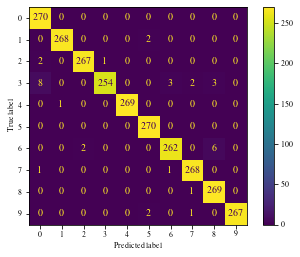

Classification training report for estimator SeqToLabelESNClassifier(input_to_node=PredefinedWeightsInputToNode(bias_scaling=1.0,
                                                                   input_activation='identity',
                                                                   input_scaling=0.9830105547524456,
                                                                   predefined_input_weights=array([[ 0.2750404 ,  0.3212066 , -0.10526009, ...,  0.        ,
         0.        ,  0.        ],
       [-0.28342554,  0.15917715, -0.5848191 , ...,  0.        ,
         0.        ,  0.        ],
       [-0.23426661,  0.56071055,  0.01936606, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [-0.4181385 ,  0.2330637 ,  0.37565753, ...,  0.        ,
         0.        ,  0.        ],
       [-0.01583754, -0.37212756,  0.3546613 , ...,  0.        ,
         0.        ,  0.        ],
       [-0.07822532, -0.05877961,  0.29404518, ...,  0.        ,
    

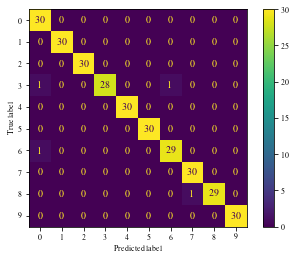

Classification test report for estimator SeqToLabelESNClassifier(input_to_node=PredefinedWeightsInputToNode(bias_scaling=1.0,
                                                                   input_activation='identity',
                                                                   input_scaling=0.9830105547524456,
                                                                   predefined_input_weights=array([[ 0.2750404 ,  0.3212066 , -0.10526009, ...,  0.        ,
         0.        ,  0.        ],
       [-0.28342554,  0.15917715, -0.5848191 , ...,  0.        ,
         0.        ,  0.        ],
       [-0.23426661,  0.56071055,  0.01936606, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [-0.4181385 ,  0.2330637 ,  0.37565753, ...,  0.        ,
         0.        ,  0.        ],
       [-0.01583754, -0.37212756,  0.3546613 , ...,  0.        ,
         0.        ,  0.        ],
       [-0.07822532, -0.05877961,  0.29404518, ...,  0.        ,
        

In [54]:
km_esn = sequential_search.best_estimator_
y_pred_train = km_esn.predict(X=X_train_scaled)
cm = confusion_matrix(y_train, y_pred_train)
cm_display = ConfusionMatrixDisplay(cm, display_labels=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]).plot()
plt.show()
print("Classification training report for estimator %s:\n%s\n" % (km_esn, classification_report(y_train, y_pred_train, digits=10)))

y_pred_test = km_esn.predict(X=X_test_scaled)
cm = confusion_matrix(y_test, y_pred_test)
cm_display = ConfusionMatrixDisplay(cm, display_labels=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]).plot()
plt.show()
print("Classification test report for estimator %s:\n%s\n" % (km_esn, classification_report(y_test, y_pred_test, digits=10)))

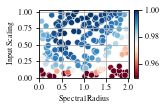

In [13]:
df = pd.DataFrame(sequential_search.all_cv_results_["step1"])
df.mean_test_score = df.mean_test_score.clip(lower=0.95)
fig = plt.figure()
ax = sns.scatterplot(x="param_spectral_radius", y="param_input_scaling", hue="mean_test_score", palette='RdBu', data=df)
plt.xlabel("Spectral Radius")
plt.ylabel("Input Scaling")

norm = plt.Normalize(0.95, 1.0)
sm = plt.cm.ScalarMappable(cmap="RdBu", norm=norm)
sm.set_array([])
plt.xlim((0, 2.01))
plt.ylim((0, 1.03))

# Remove the legend and add a colorbar
ax.get_legend().remove()
ax.figure.colorbar(sm)
fig.set_size_inches(2, 1.25)
ax.yaxis.set_major_locator(ticker.MaxNLocator(5))
ax.xaxis.set_major_locator(ticker.MaxNLocator(5))
plt.grid()
plt.savefig('KM_ESN_IS_SR_sparse.pdf', bbox_inches='tight', pad_inches=0)

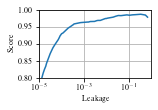

In [12]:
df = pd.DataFrame(sequential_search.all_cv_results_["step2"])
fig = plt.figure()
fig.set_size_inches(2, 1.25)
ax = sns.lineplot(data=df, x="param_leakage", y="mean_test_score")
ax.set_xscale('log')
plt.xlabel("Leakage")
plt.ylabel("Score")
plt.xlim((1e-5, 1e0))
plt.ylim((0.8, 1.0))
# ax.xaxis.set_major_locator(ticker.MaxNLocator(10))
ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('%.2f'))
plt.grid()
plt.savefig('KM_ESN_LR_sparse.pdf', bbox_inches='tight', pad_inches=0)

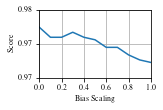

In [49]:
df = pd.DataFrame(sequential_search.all_cv_results_["step3"])
fig = plt.figure()
fig.set_size_inches(2, 1.25)
ax = sns.lineplot(data=df, x="param_bias_scaling", y="mean_test_score")
plt.xlabel("Bias Scaling")
plt.ylabel("Score")
plt.xlim((0, 1))
plt.ylim((0.97, 0.98))
ax.xaxis.set_major_locator(ticker.MaxNLocator(5))
ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('%.2f'))
plt.grid()
plt.savefig('KM_ESN_BS.pdf', bbox_inches='tight', pad_inches=0)

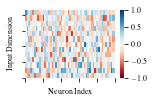

In [50]:
idx = np.random.randint(0, 400, 50)

fig = plt.figure()
fig.set_size_inches(2, 1.25)
ax = sns.heatmap(data=sequential_search.best_estimator_.input_to_node.input_weights[:, idx], cmap="RdBu", vmin=-1.0, vmax=1.0)
ax.invert_yaxis()
ax.yaxis.set_major_locator(ticker.MaxNLocator(5))
ax.xaxis.set_major_locator(ticker.MaxNLocator(5))
plt.xlabel("Neuron Index")
plt.ylabel("Input Dimension")
# plt.imshow(sequential_search.best_estimator_.input_to_node.input_weights.todense()[:, idx])
# plt.colorbar()
plt.savefig('KM_ESN_Input_Weights.pdf', bbox_inches='tight', pad_inches=0)

Increase the reservoir size

In [61]:
print(sequential_search.all_best_params_)
print(sequential_search.all_best_score_)

constant_params = sequential_search.best_estimator_.get_params()
constant_params.pop('hidden_layer_size')
constant_params.pop('random_state')
constant_params.pop('predefined_input_weights')
param_grid = {'hidden_layer_size': [50, 100, 200, 400, 800, 1600, 3200, 6400],
              'random_state': range(1, 11)}

for params in ParameterGrid(param_grid):
    if params['hidden_layer_size'] > 400:
        kmeans = MiniBatchKMeans(n_clusters=400, n_init=200, reassignment_ratio=0, max_no_improvement=50, init='k-means++', verbose=0, random_state=params['random_state'])
        kmeans.fit(X=np.concatenate(np.concatenate((X_train_scaled, X_test_scaled))))
        w_in = np.divide(kmeans.cluster_centers_, np.linalg.norm(kmeans.cluster_centers_, axis=1)[:, None])
        w_in = np.pad(w_in, ((0, params['hidden_layer_size'] - 400), (0, 0)), mode='constant', constant_values=0)
    else:
        kmeans = MiniBatchKMeans(n_clusters=params['hidden_layer_size'], n_init=200, reassignment_ratio=0, max_no_improvement=50, init='k-means++', verbose=0, random_state=params['random_state'])
        kmeans.fit(X=np.concatenate(np.concatenate((X_train_scaled, X_test_scaled))))
        w_in = np.divide(kmeans.cluster_centers_, np.linalg.norm(kmeans.cluster_centers_, axis=1)[:, None])
    km_esn = clone(sequential_search.best_estimator_)
    km_esn.input_to_node = PredefinedWeightsInputToNode(predefined_input_weights=w_in.T)
    km_esn.set_params(**constant_params, **params)
    km_esn.fit(X=X_train_scaled, y=y_train, n_jobs=8)
    score = accuracy_score(y_test, km_esn.predict(X_test_scaled))
    print("KM-ESN with params {0} achieved score of {1}".format(params, score))

{'step1': {'input_scaling': 0.9248643902204485, 'spectral_radius': 0.7403174005108888}, 'step2': {'leakage': 0.3520481045526037}, 'step3': {'bias_scaling': 0.9}, 'step4': {'alpha': 0.005450293694558251}}
{'step1': 0.9840740740740742, 'step2': 0.9862962962962962, 'step3': 0.9922222222222221, 'step4': 0.9922222222222222}


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\App

C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\App

C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\App

C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\App

C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\App

KM-ESN with params {'hidden_layer_size': 800, 'random_state': 1} achieved score of 0.99


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\App

C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\App

C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\App

C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\App

C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\App

KM-ESN with params {'hidden_layer_size': 800, 'random_state': 2} achieved score of 0.9933333333333333


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\App

C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\App

C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\App

C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\App

C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\App

KM-ESN with params {'hidden_layer_size': 800, 'random_state': 3} achieved score of 0.9933333333333333


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\App

C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\App

C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\App

C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\App

C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\App

KM-ESN with params {'hidden_layer_size': 800, 'random_state': 4} achieved score of 0.9866666666666667


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\App

C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\App

C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\App

C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\App

C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\App

KM-ESN with params {'hidden_layer_size': 800, 'random_state': 5} achieved score of 0.99


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\App

C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\App

C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\App

C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\App

C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\App

KM-ESN with params {'hidden_layer_size': 800, 'random_state': 6} achieved score of 0.99


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\App

C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\App

C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\App

C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\App

C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\App

KM-ESN with params {'hidden_layer_size': 800, 'random_state': 7} achieved score of 0.9833333333333333


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\App

C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\App

C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\App

C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\App

C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\App

KM-ESN with params {'hidden_layer_size': 800, 'random_state': 8} achieved score of 0.98


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\App

C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\App

C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\App

C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\App

C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\App

KM-ESN with params {'hidden_layer_size': 800, 'random_state': 9} achieved score of 0.9866666666666667


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\App

C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\App

C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\App

C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\App

C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\App

KM-ESN with params {'hidden_layer_size': 800, 'random_state': 10} achieved score of 0.99


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\App

C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\App

C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\App

C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\App

C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\App

KM-ESN with params {'hidden_layer_size': 1600, 'random_state': 1} achieved score of 0.99


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\App

C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\App

C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\App

C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\App

C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\App

KM-ESN with params {'hidden_layer_size': 1600, 'random_state': 2} achieved score of 0.99


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\App

C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\App

C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\App

C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\App

C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\App

KM-ESN with params {'hidden_layer_size': 1600, 'random_state': 3} achieved score of 0.99


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\App

C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\App

C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\App

C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\App

C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\App

KM-ESN with params {'hidden_layer_size': 1600, 'random_state': 4} achieved score of 0.99


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\App

C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\App

C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\App

C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\App

C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\App

KM-ESN with params {'hidden_layer_size': 1600, 'random_state': 5} achieved score of 0.99


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\App

C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\App

C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\App

C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\App

C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\App

KM-ESN with params {'hidden_layer_size': 1600, 'random_state': 6} achieved score of 0.9866666666666667


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\App

C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\App

C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\App

C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\App

C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\App

KM-ESN with params {'hidden_layer_size': 1600, 'random_state': 7} achieved score of 0.99


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\App

C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\App

C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\App

C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\App

C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\App

KM-ESN with params {'hidden_layer_size': 1600, 'random_state': 8} achieved score of 0.99


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\App

C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\App

C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\App

C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\App

C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\App

KM-ESN with params {'hidden_layer_size': 1600, 'random_state': 9} achieved score of 0.99


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\App

C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\App

C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\App

C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\App

C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\App

KM-ESN with params {'hidden_layer_size': 1600, 'random_state': 10} achieved score of 0.9866666666666667


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\App

C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\App

C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\App

C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\App

C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\App

KM-ESN with params {'hidden_layer_size': 3200, 'random_state': 1} achieved score of 0.9933333333333333


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\App

C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\App

C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\App

C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\App

C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\App

KM-ESN with params {'hidden_layer_size': 3200, 'random_state': 2} achieved score of 0.9966666666666667


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\App

C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\App

C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\App

C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\App

C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\App

KM-ESN with params {'hidden_layer_size': 3200, 'random_state': 3} achieved score of 0.9933333333333333


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\App

C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\App

C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\App

C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\App

C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\App

KM-ESN with params {'hidden_layer_size': 3200, 'random_state': 4} achieved score of 0.9933333333333333


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\App

C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\App

C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\App

C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\App

C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\App

KM-ESN with params {'hidden_layer_size': 3200, 'random_state': 5} achieved score of 0.9933333333333333


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\App

C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\App

C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\App

C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\App

C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\App

KM-ESN with params {'hidden_layer_size': 3200, 'random_state': 6} achieved score of 0.9966666666666667


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\App

C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\App

C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\App

C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\App

C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\App

KM-ESN with params {'hidden_layer_size': 3200, 'random_state': 7} achieved score of 0.9933333333333333


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\App

C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\App

C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\App

C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\App

C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\App

KM-ESN with params {'hidden_layer_size': 3200, 'random_state': 8} achieved score of 0.9966666666666667


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\App

C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\App

C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\App

C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\App

C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\App

KM-ESN with params {'hidden_layer_size': 3200, 'random_state': 9} achieved score of 0.9966666666666667


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\App

C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\App

C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\App

C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\App

C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\App

KM-ESN with params {'hidden_layer_size': 3200, 'random_state': 10} achieved score of 0.9966666666666667


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\App

C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\App

C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\App

C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\App

C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\App

KM-ESN with params {'hidden_layer_size': 6400, 'random_state': 1} achieved score of 0.9933333333333333


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\App

C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\App

C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\App

C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\App

C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\App

KM-ESN with params {'hidden_layer_size': 6400, 'random_state': 2} achieved score of 0.9933333333333333


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\App

C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\App

C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\App

C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\App

C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\App

KM-ESN with params {'hidden_layer_size': 6400, 'random_state': 3} achieved score of 0.9966666666666667


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\App

C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\App

C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\App

C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\App

C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\App

AttributeError: type object 'ArpackNoConvergence' has no attribute 'eigenvalues'

Visualization of a reservoir state from the training set

IndexError: index 69 is out of bounds for axis 1 with size 50

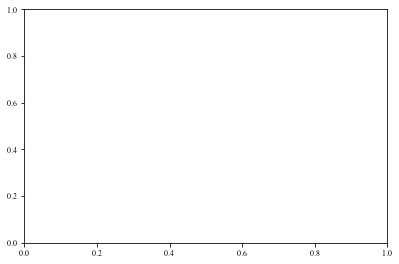

In [28]:
_ = km_esn.predict(X=X_train_scaled[361])
fig = plt.figure()
fig.subplots_adjust(left=.15, bottom=.16, right=.99, top=.97)
ax = plt.gca()
rng = np.random.default_rng(12345)
idx = rng.choice(100, 50)
im = plt.imshow(km_esn.hidden_layer_state[:, idx].T,vmin=-1, vmax=1)
plt.xlim([0, km_esn.hidden_layer_state.shape[0]])
plt.ylim([0, 50])
plt.xlabel(r'$n$')
plt.ylabel(r'$\mathbf{r}[n]$')
plt.grid()
# create an axes on the right side of ax. The width of cax will be 5%
# of ax and the padding between cax and ax will be fixed at 0.05 inch.
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="3%", pad=0.2)
tick_locator = ticker.MaxNLocator(nbins=5)
cb = plt.colorbar(im, cax=cax)
cb.locator = tick_locator
cb.update_ticks()
fig.set_size_inches(0.5*width, height)
# plt.savefig('input_scaling_rand_train.pdf', bbox_inches = 'tight', pad_inches = 0)

Visualization of a reservoir state from the test set

IndexError: index 69 is out of bounds for axis 1 with size 50

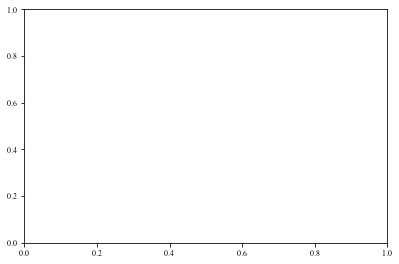

In [29]:
_ = km_esn.predict(X=X_test_scaled[0])
fig = plt.figure()
fig.subplots_adjust(left=.15, bottom=.16, right=.99, top=.97)
ax = plt.gca()
rng = np.random.default_rng(12345)
idx = rng.choice(100, 50)
im = plt.imshow(km_esn.hidden_layer_state[:, idx].T,vmin=-1, vmax=1)
plt.xlim([0, km_esn.hidden_layer_state.shape[0]])
plt.ylim([0, 50])
plt.xlabel(r'$n$')
plt.ylabel(r'$\mathbf{r}[n]$')
plt.grid()
# create an axes on the right side of ax. The width of cax will be 5%
# of ax and the padding between cax and ax will be fixed at 0.05 inch.
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="3%", pad=0.2)
cb = plt.colorbar(im, cax=cax)
cb.locator = tick_locator
cb.update_ticks()
fig.set_size_inches(0.5*width, height)
# plt.savefig('spectral_radius_rand_test.pdf', bbox_inches = 'tight', pad_inches = 0)

Random experiments

In [ ]:
rng = np.random.default_rng(12345)
params = {"random_state": rng.integers(100, size=20)}
gs_km_esn = GridSearchCV(clone(km_esn), params, scoring=make_scorer(accuracy_score), n_jobs=-1).fit(X_train_scaled, y_train)

In [ ]:
gs_km_esn.cv_results_["mean_test_score"].mean(), gs_km_esn.cv_results_["mean_test_score"].var()